<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Causal Inference In Statistics - A Primer</h1>
        <h1>3.4 Front-Door Criterion</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
    <div style="float: right; margin-right:10px;"> <p><a href="https://amzn.to/3gsFlkO" target=_blank><img src='data/causality.jpeg' width='100px'>
        <!--Amazon Affiliate Link--></a></p></div>
</div>

In [20]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

from CausalModel import CausalModel

import watermark

%load_ext watermark
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


We start by print out the versions of the libraries we're using for future reference

In [21]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: f7b1abb57541776dc786174deb102ca4ab864df6

pandas    : 2.2.3
matplotlib: 3.10.0
watermark : 2.5.0
numpy     : 2.2.4



Load default figure style

In [22]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [23]:
G = CausalModel()
G.add_causation('X', 'Z')
G.add_causation('Z', 'Y')
G.add_causation('U', 'X')
G.add_causation('U', 'Y')

G.pos = {'Z': (0.5, 0), 'X':(0,0), 'Y':(1, 0), 'U':(0.5, 1)}

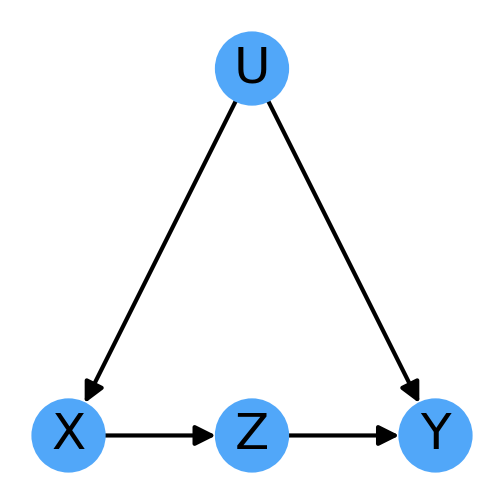

In [24]:
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
G.plot(ax=ax)

In [25]:
G.save_model('dags/Primer.Fig.3.10b.dot')

Let us define our causality table

In [26]:
data = [
    ['Tar', 'Smokers', 'No Cancer', 323],
    ['Tar', 'Smokers', 'Cancer', 57],
    ['Tar', 'Non Smokers', 'No Cancer', 1],
    ['Tar', 'Non Smokers', 'Cancer', 19],

    ['No Tar', 'Smokers', 'No Cancer',18],
    ['No Tar', 'Smokers', 'Cancer', 2],
    ['No Tar', 'Non Smokers', 'No Cancer', 38],
    ['No Tar', 'Non Smokers', 'Cancer', 342]
]

Smoking = pd.DataFrame(data, columns=['Tar', 'Smoking', 'Cancer', 'Count'])

The Total number of test subjects is

In [27]:
Total = Smoking['Count'].sum()
Total

np.int64(800)

The $P\left(Smoking\right)$ is:

In [28]:
P_Smoking = Smoking[['Smoking', 'Count']].groupby('Smoking').sum()/Total
P_Smoking

,Count
Smoking,
Non Smokers,0.5
Smokers,0.5


And the probability of having cancer is:

In [29]:
print(Smoking.groupby('Cancer').sum())
print(Total)
P_Cancer = Smoking.groupby('Cancer')['Count'].sum()/Total
P_Cancer

                          Tar                               Smoking  Count
Cancer                                                                    
Cancer     TarTarNo TarNo Tar  SmokersNon SmokersSmokersNon Smokers    420
No Cancer  TarTarNo TarNo Tar  SmokersNon SmokersSmokersNon Smokers    380
800


Cancer
Cancer       0.525
No Cancer    0.475
Name: Count, dtype: float64

The Joint probability of Smoking and Tar is:

In [30]:
PXZ = Smoking[['Tar', 'Smoking', 'Count']].groupby(['Tar', 'Smoking']).sum()
PXZ

Count
Tar    Smoking           
No Tar Non Smokers    380
       Smokers         20
Tar    Non Smokers     20
       Smokers        380

And the $P\left(Tar | Smoking\right)$ is:

In [31]:
P_Tar_Smoking = PXZ/Smoking[['Smoking', 'Count']].groupby('Smoking').sum()
P_Tar_Smoking

Count
Tar    Smoking           
No Tar Non Smokers   0.95
       Smokers       0.05
Tar    Non Smokers   0.05
       Smokers       0.95

So it seems that smoking increases the probability of you developing tar in your lungs

Now let's compute $P\left(Cancer|Tar, Smoking\right)$ the probability of Cancer given Tar and Smoking,

In [32]:
def norm(x):
    x.Count = x.Count/float(PXZ.loc[(x.Tar, x.Smoking)])
    return x

In [33]:
P_YXZ = Smoking.apply(norm, axis=1).set_index(['Smoking', 'Tar'])
P_YXZ

Cancer  Count
Smoking     Tar                     
Smokers     Tar     No Cancer   0.85
            Tar        Cancer   0.15
Non Smokers Tar     No Cancer   0.05
            Tar        Cancer   0.95
Smokers     No Tar  No Cancer   0.90
            No Tar     Cancer   0.10
Non Smokers No Tar  No Cancer   0.10
            No Tar     Cancer   0.90

For simplicity, let's subset to just the probability of developing cancer

In [34]:
Cancer = P_YXZ[P_YXZ.Cancer == 'Cancer'][['Count']].copy()
Cancer.columns=['P(Cancer)']
Cancer

,,P(Cancer)
Smoking,Tar,
Smokers,Tar,0.15
Non Smokers,Tar,0.95
Smokers,No Tar,0.10
Non Smokers,No Tar,0.90


From this table it seems that Non-Smokers are much more likely to develop cancer than smokers!

Finally, we can put all the pieces together to compute $P\left(Cancer|do\left(Smoker\right)\right)$

In [35]:
Prob1 = 0
Y = 'Cancer'
X = 'Smokers'

for Z in ['Tar', 'No Tar']:
    for Xl in ['Smokers', 'Non Smokers']:
        Prob1 += Cancer.loc[Xl, Z] * P_Smoking.loc[Xl] * P_Tar_Smoking.loc[Z, X]
        
print(Prob1)

Count       NaN
P(Cancer)   NaN
dtype: float64


And $P\left(Cancer|do\left(Non~Smoker\right)\right)$

In [36]:
Prob0 = 0
Y = 'Cancer'
X = 'Non Smokers'

for Z in ['Tar', 'No Tar']:
    for Xl in ['Smokers', 'Non Smokers']:
        Prob0 += Cancer.loc[Xl, Z] * P_Smoking.loc[Xl] * P_Tar_Smoking.loc[Z, X]
        
print(Prob0)

Count       NaN
P(Cancer)   NaN
dtype: float64


The differnece is then:

In [37]:
Prob1-Prob0

Count       NaN
P(Cancer)   NaN
dtype: float64

Indicating that smoking does increase your probability of developing cancer!

In [38]:
G = CausalModel('dags/Primer.Fig.3.8.dot')

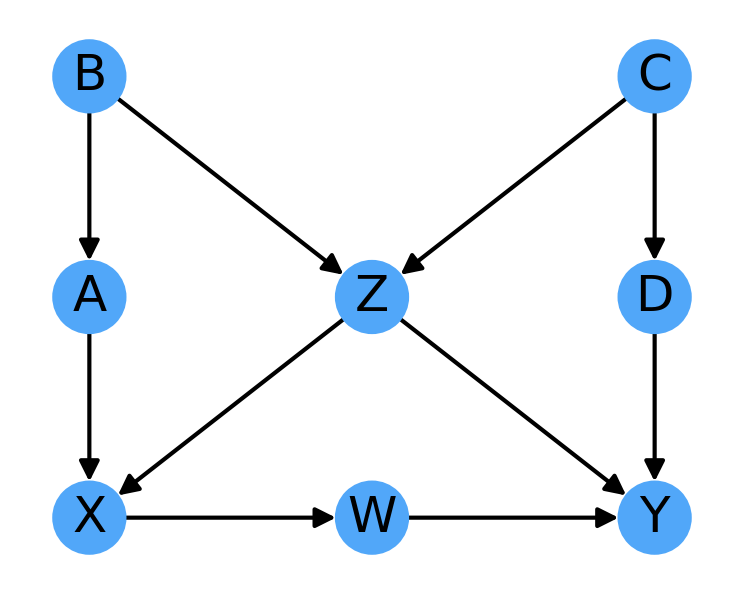

In [39]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
G.plot(ax=ax)

From this graph we can determine that W obeys the Front-Door criterion with respect to X and Y.

It intercepts the only path between X and Y

In [40]:
G.directed_paths('X', 'Y')

{('X', 'W', 'Y')}

All the backdoor paths between X and W are blocked by the collider at Z

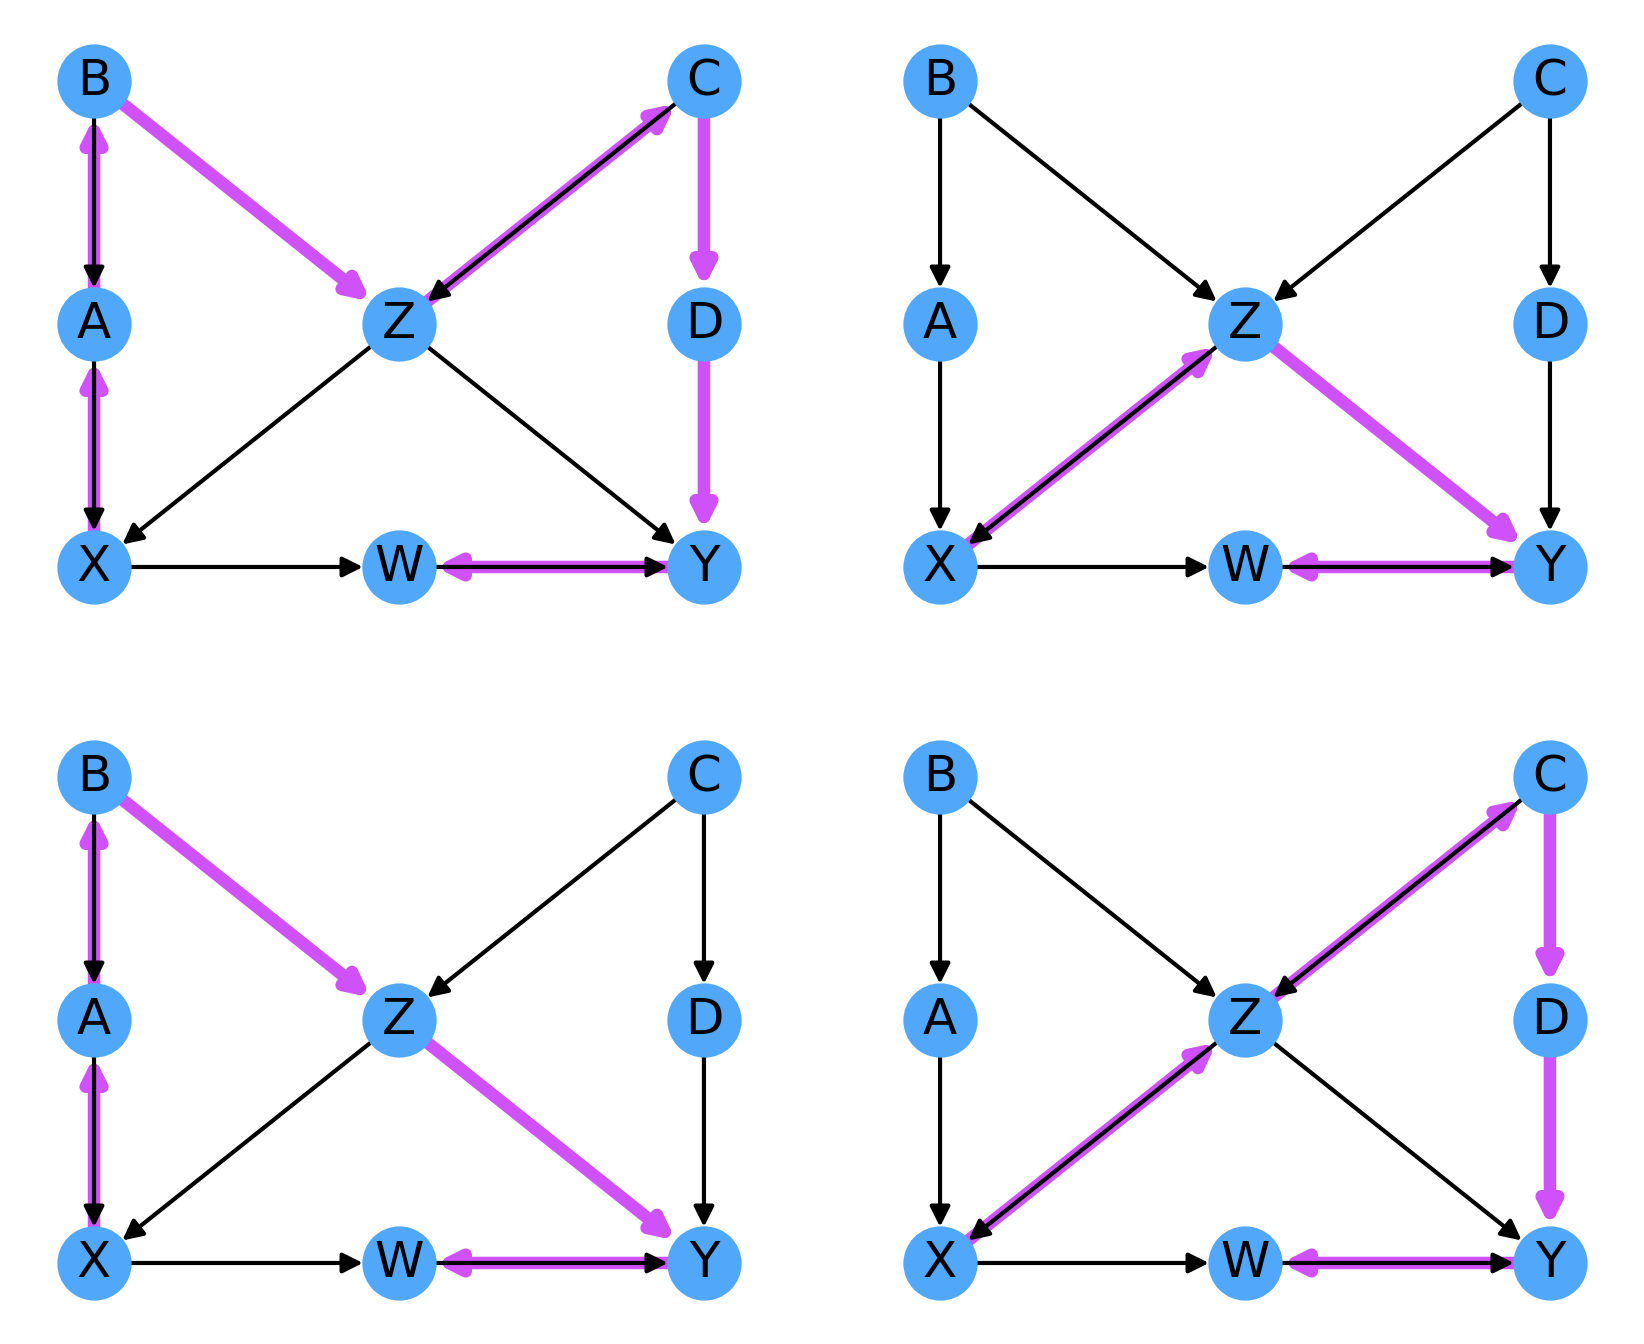

In [41]:
XW = G.backdoor_paths('X', 'W')

fig, ax_lst = plt.subplots(2, 2, figsize=(6, 5))
ax_lst = np.array(ax_lst).flatten()

pos = 0
for i, path in enumerate(XW):
    G.plot_path(path, ax=ax_lst[pos])
    pos += 1

ax_lst[-1].axis('off');

And finally, all the backdoor paths between W and Y are blocked by X

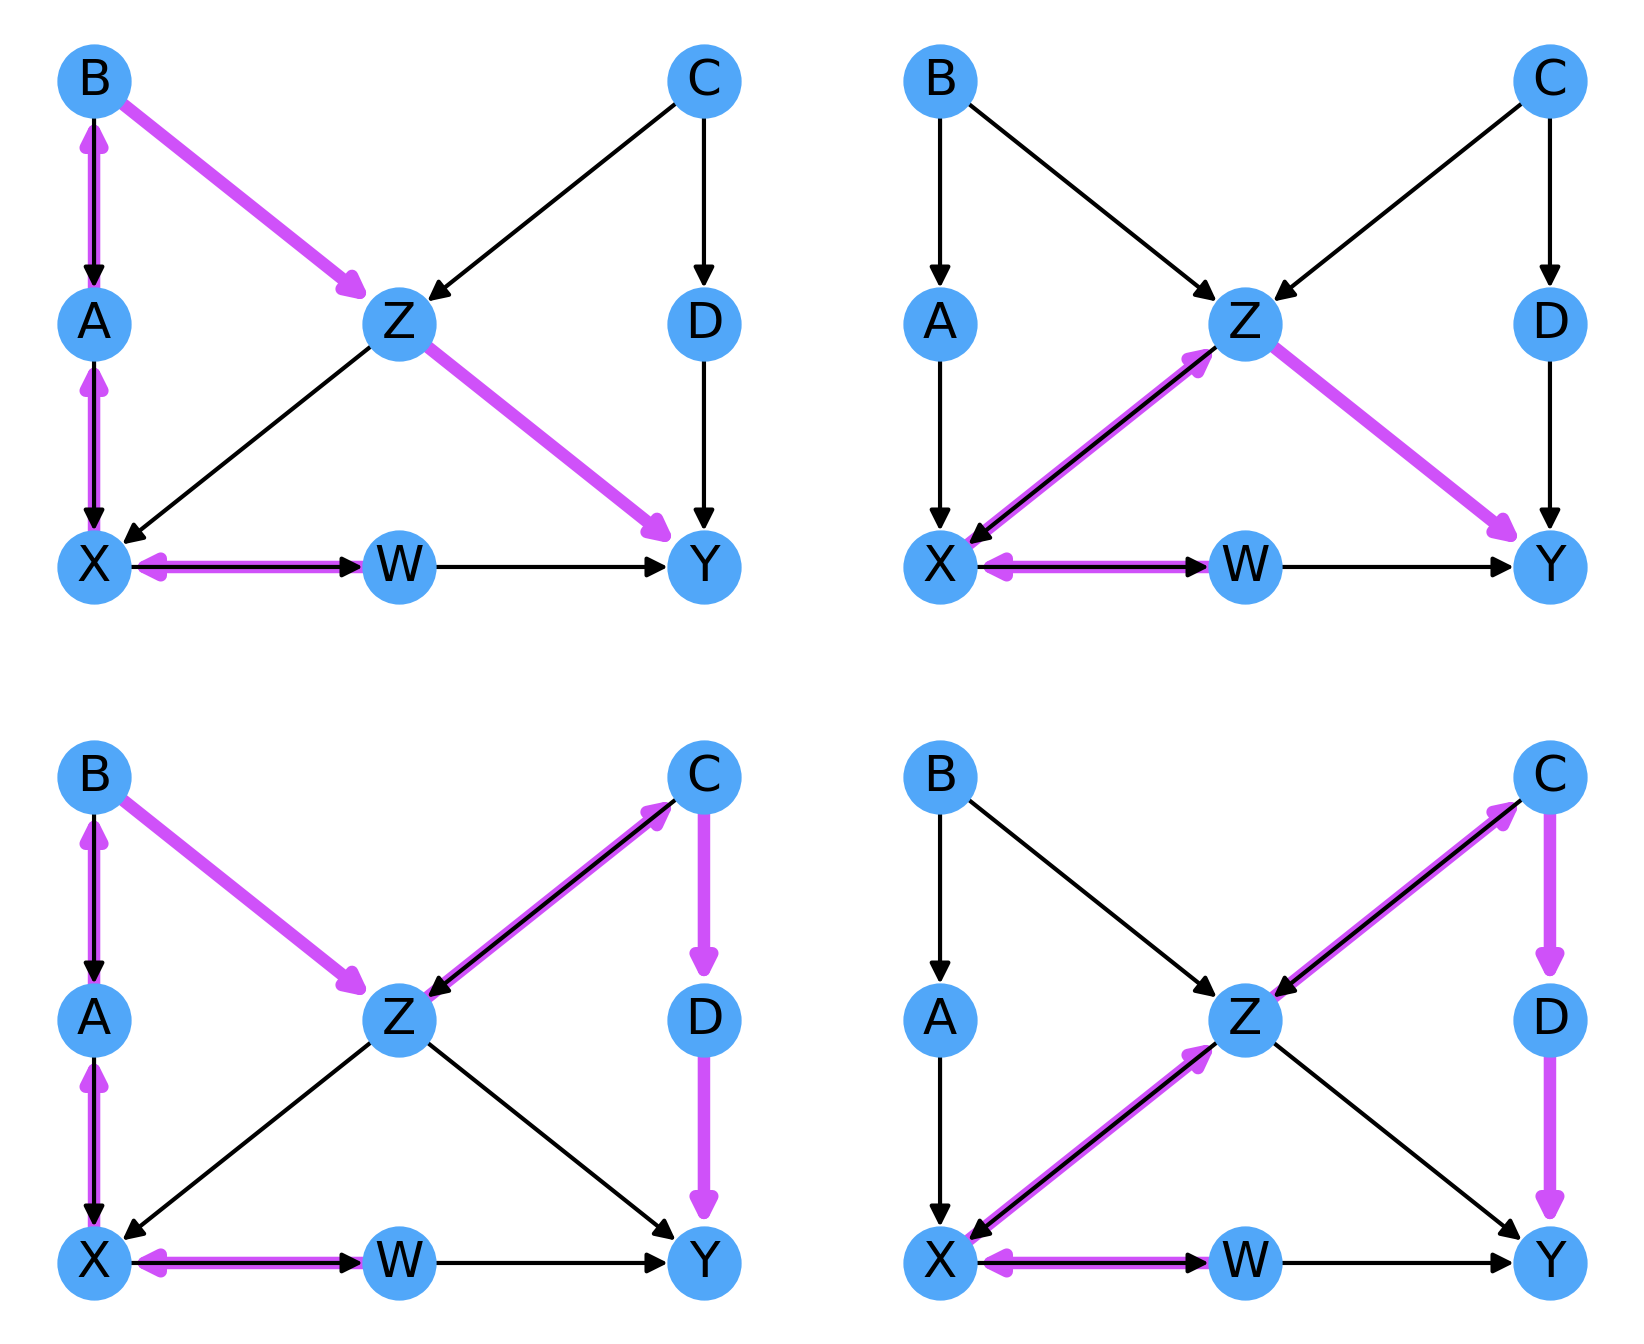

In [42]:
WY = G.backdoor_paths('W', 'Y')

fig, ax_lst = plt.subplots(2, 2, figsize=(6, 5))
ax_lst = np.array(ax_lst).flatten()

pos = 0
for i, path in enumerate(WY):
    G.plot_path(path, ax=ax_lst[pos])
    pos += 1

ax_lst[-1].axis('off');

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>